In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
import pcmdpy as ppy
import easydarkfigs
import seaborn as sns
%matplotlib inline

In [2]:
%set_darkfigdir figures_dark/

In [3]:
%set_lightfigdir figures/

# Alignment and Drizzling

In [4]:
files = {'F475W': ['../data/NGC3377/raw/NGC3377_F475W_EXP{:d}_flc.fits'.format(i) for i in range(1, 5)],
         'F850LP': ['../data/NGC3377/raw/NGC3377_F850LP_EXP{:d}_flc.fits'.format(i) for i in range(1, 5)]}
outputs = {'F475W': '../data/NGC3377/reduced/NGC3377_F475W_cps_drc.fits',
          'F850LP': '../data/NGC3377/reduced/NGC3377_F850LP_cps_drc.fits'}
diff_im = '../data/NGC3377/reduced/NGC3377_g-z.fits'
darks = {}

In [27]:
%%time
ppy.data.alignment.drizzle_many(files, outputs, reference_filter='F850LP', verbose=True, realign_only=True, realign_kwargs={'threshold': 0.2, 'refimagefindcfg':{'treshold':0.2}},
                                drizzle_kwargs={'final_units': 'cps'}, redrizzle_kwargs={'final_units': 'cps'})

*****************************************************
Realign and Redrizzle relative to F850LP
--F475W: Realigning
{'conv_width': 4.0, 'threshold': 0.2, 'shiftfile': False, 'updatehdr': True, 'writecat': False, 'clean': True, 'residplot': 'NoPlot', 'see2dplot': False, 'reusename': True, 'interactive': False, 'updatewcs': False, 'enforce_user_order': True, 'expand_refcat': True, 'wcsname': 'TWEAK_F850LP', 'refimage': '../data/NGC3377/reduced/NGC3377_F850LP_cps_drc.fits', 'nclip': 10, 'refimagefindcfg': {'treshold': 0.2}}
Setting up logfile :  tweakreg.log
TweakReg Version 1.4.7(18-April-2018) started at: 13:39:12.174 (08/04/2019) 

Version Information
--------------------
Python Version [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
numpy Version -> 1.15.1 
astropy Version -> 3.1.2 
stwcs Version -> 1.4.2 

Finding shifts for: 
    /Users/bcook/pCMDs/pixcmd/data/NGC3377/reduced/NGC3377_F475W_cps_drc.fits

==

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]



Processing /Users/bcook/pCMDs/pixcmd/data/NGC3377/raw/NGC3377_F475W_EXP1_flc.fits['SCI',1]

Updating header for /Users/bcook/pCMDs/pixcmd/data/NGC3377/raw/NGC3377_F475W_EXP1_flc.fits[1]
WCS Keywords

CD_11  CD_12: -4.327235159977407e-06 -1.3546908164425386e-05
CD_21  CD_22: -1.3156383878167725e-05 3.4425734356754065e-06
CRVAL    : 161.9442975396539 13.981979769017753
CRPIX    : 2048.0 1024.0
NAXIS    : 4096 2048
Plate Scale : 0.0498580494588387
ORIENTAT : -75.74166836674719
WCSNAME  :  TWEAK_F850LP_1

Processing /Users/bcook/pCMDs/pixcmd/data/NGC3377/raw/NGC3377_F475W_EXP1_flc.fits['SCI',2]

Updating header for /Users/bcook/pCMDs/pixcmd/data/NGC3377/raw/NGC3377_F475W_EXP1_flc.fits[4]
WCS Keywords

CD_11  CD_12: -4.448568336792278e-06 -1.31206067646218e-05
CD_21  CD_22: -1.2945439563654027e-05 3.2262386097464375e-06
CRVAL    : 161.9154286510241 13.989034547715926
CRPIX    : 2048.0 1024.0
NAXIS    : 4096 2048
Plate Scale : 0.049277470127034324
ORIENTAT : -76.1855515837868
WCSNAME  :  TW

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pi


....Updating header for /Users/bcook/pCMDs/pixcmd/data/NGC3377/raw/NGC3377_F475W_EXP2_flc.fits...


Processing /Users/bcook/pCMDs/pixcmd/data/NGC3377/raw/NGC3377_F475W_EXP2_flc.fits['SCI',1]

Updating header for /Users/bcook/pCMDs/pixcmd/data/NGC3377/raw/NGC3377_F475W_EXP2_flc.fits[1]
WCS Keywords

CD_11  CD_12: -4.327308411224924e-06 -1.3547089306568887e-05
CD_21  CD_22: -1.315655873735608e-05 3.442635060839031e-06
CRVAL    : 161.94514846947763 13.98184095217631
CRPIX    : 2048.0 1024.0
NAXIS    : 4096 2048
Plate Scale : 0.049858729820323695
ORIENTAT : -75.74160641903748
WCSNAME  :  TWEAK_F850LP_1

Processing /Users/bcook/pCMDs/pixcmd/data/NGC3377/raw/NGC3377_F475W_EXP2_flc.fits['SCI',2]

Updating header for /Users/bcook/pCMDs/pixcmd/data/NGC3377/raw/NGC3377_F475W_EXP2_flc.fits[4]
WCS Keywords

CD_11  CD_12: -4.448643082374041e-06 -1.3120782364694608e-05
CD_21  CD_22: -1.2945611412303152e-05 3.2262968569131705e-06
CRVAL    : 161.91627921224293 13.988895857439195
CRPIX    : 2048.0 102

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pi


....Updating header for /Users/bcook/pCMDs/pixcmd/data/NGC3377/raw/NGC3377_F475W_EXP3_flc.fits...


Processing /Users/bcook/pCMDs/pixcmd/data/NGC3377/raw/NGC3377_F475W_EXP3_flc.fits['SCI',1]

Updating header for /Users/bcook/pCMDs/pixcmd/data/NGC3377/raw/NGC3377_F475W_EXP3_flc.fits[1]
WCS Keywords

CD_11  CD_12: -4.327653354880332e-06 -1.354713619789228e-05
CD_21  CD_22: -1.3156581503198647e-05 3.44298074245326e-06
CRVAL    : 161.94599892601795 13.981703571351735
CRPIX    : 2048.0 1024.0
NAXIS    : 4096 2048
Plate Scale : 0.04985919566306277
ORIENTAT : -75.74028044167643
WCSNAME  :  TWEAK_F850LP_1

Processing /Users/bcook/pCMDs/pixcmd/data/NGC3377/raw/NGC3377_F475W_EXP3_flc.fits['SCI',2]

Updating header for /Users/bcook/pCMDs/pixcmd/data/NGC3377/raw/NGC3377_F475W_EXP3_flc.fits[4]
WCS Keywords

CD_11  CD_12: -4.4489842004807526e-06 -1.312083026025061e-05
CD_21  CD_22: -1.2945629414445101e-05 3.22663062599214e-06
CRVAL    : 161.9171295844623 13.98875919084146
CRPIX    : 2048.0 1024.0
N

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pi


....Updating header for /Users/bcook/pCMDs/pixcmd/data/NGC3377/raw/NGC3377_F475W_EXP4_flc.fits...


Processing /Users/bcook/pCMDs/pixcmd/data/NGC3377/raw/NGC3377_F475W_EXP4_flc.fits['SCI',1]

Updating header for /Users/bcook/pCMDs/pixcmd/data/NGC3377/raw/NGC3377_F475W_EXP4_flc.fits[1]
WCS Keywords

CD_11  CD_12: -4.3289751824250246e-06 -1.3545673285246101e-05
CD_21  CD_22: -1.315503727254101e-05 3.4444189287754617e-06
CRVAL    : 161.9468458730631 13.981561189086372
CRPIX    : 2048.0 1024.0
NAXIS    : 4096 2048
Plate Scale : 0.049855402151632505
ORIENTAT : -75.733089268452
WCSNAME  :  TWEAK_F850LP_1

Processing /Users/bcook/pCMDs/pixcmd/data/NGC3377/raw/NGC3377_F475W_EXP4_flc.fits['SCI',2]

Updating header for /Users/bcook/pCMDs/pixcmd/data/NGC3377/raw/NGC3377_F475W_EXP4_flc.fits[4]
WCS Keywords

CD_11  CD_12: -4.45027053443226e-06 -1.3119426892908981e-05
CD_21  CD_22: -1.2944085941058284e-05 3.2280319230006278e-06
CRVAL    : 161.91797965849796 13.988619787575741
CRPIX    : 2048.0 1024

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pi

--F475W: Redrizzling
    Drizzling Images with lanczos3 kernel to ../data/NGC3377/reduced/NGC3377_F475W_cps_drc.fits
{'clean': True, 'build': True, 'skysub': False, 'final_units': 'cps', 'mdriztab': False, 'combine_type': 'median', 'combine_nhigh': 1, 'final_kernel': 'lanczos3', 'final_rot': None, 'final_wcs': True, 'final_refimage': '../data/NGC3377/reduced/NGC3377_F850LP_cps_drc.fits'}
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 13:39:40.432 (08/04/2019)

==== Processing Step  Initialization  started at  13:39:40.436 (08/04/2019)
Creating OUTPUT WCS from ../data/NGC3377/reduced/NGC3377_F850LP_cps_drc.fits[1]
WCS Keywords

CD_11  CD_12: -1.3888888888888e-05 -3.5656053071188e-23
CD_21  CD_22: 1.15833191161965e-22 1.38888888888888e-05
CRVAL    : 161.9312076922945 13.98505491526511
CRPIX    : 2719.328398196752 2658.16742174887
NAXIS    : 5439 5315
Plate Scale : 0.049999999999996804
ORIENTAT : -1.470917775652965e-16
***********

In [28]:
im1 = fits.getdata('../data/NGC3377/reduced/NGC3377_F850LP_drc.fits')
im2 = fits.getdata('../data/NGC3377/reduced/NGC3377_F850LP_cps_drc.fits')
exp = fits.getdata('../data/NGC3377/reduced/NGC3377_F850LP_drc.fits', 'WHT')

In [29]:
regions = fits.getdata('../data/NGC3377/reduced/NGC3377_F850LP_drc.fits', 'REGIONS')

In [31]:
fits.writeto('../data/NGC3377/reduced/ratio.fits', im1/im2, overwrite=True)

In [32]:
f = ppy.instrument.default_ngc3377_filters()[0]

In [33]:
mags1 = f.counts_to_mag(im1, mag_system='vega')

/Users/bcook/pCMDs/pixcmd/pcmdpy/pcmdpy/simulation/gpu_utils.py:267: RuntimeWarning: invalid value encountered in log10
  return np.log10(array_in)


In [38]:
mags2 = f.counts_to_mag(im2*f._exposure, mag_system='vega')

/Users/bcook/pCMDs/pixcmd/pcmdpy/pcmdpy/simulation/gpu_utils.py:267: RuntimeWarning: invalid value encountered in log10
  return np.log10(array_in)


/Users/bcook/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


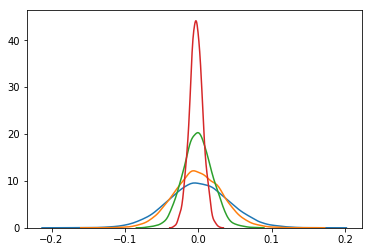

In [39]:
sns.kdeplot(mags1[regions == 41] - mags2[regions == 41])
sns.kdeplot(mags1[regions == 97] - mags2[regions == 97])
sns.kdeplot(mags1[regions == 173] - mags2[regions == 173])
sns.kdeplot(mags1[regions == 241] - mags2[regions == 241])

In [41]:
c = 215821 - 175*269

In [42]:
f.counts_to_mag(c)

19.977727473363558

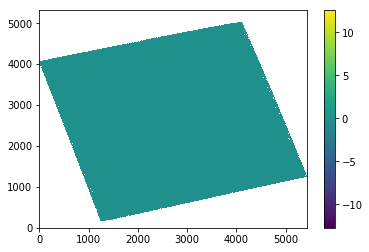

In [14]:
plt.imshow(mags1-mags2);
plt.colorbar()

In [18]:
x = (im1/im2) - exp

In [ ]:
sns.regplot((im1/im2).flatten(), exp.flatten(), x_bins=np.linspace(1000, 6000, 100), x_estimator=np.median, fit_reg=False)

/Users/bcook/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


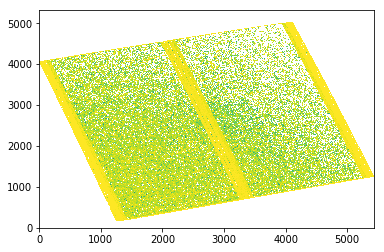

In [21]:
plt.imshow(x, norm=mpl.colors.LogNorm(vmin=1e-3, vmax=1e3))

Setting up logfile :  tweakreg.log
TweakReg Version 1.4.7(18-April-2018) started at: 15:24:44.717 (17/03/2019) 

Version Information
--------------------
Python Version [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
numpy Version -> 1.15.1 
astropy Version -> 3.1.2 
stwcs Version -> 1.4.2 

Finding shifts for: 
    /Users/bcook/pCMDs/pixcmd/data/NGC3377/reduced/NGC3377_F850LP_drc.fits
    /Users/bcook/pCMDs/pixcmd/data/NGC3377/reduced/NGC3377_F475W_drc.fits

===  Source finding for image '/Users/bcook/pCMDs/pixcmd/data/NGC3377/reduced/NGC3377_F850LP_drc.fits':
  #  Source finding for '/Users/bcook/pCMDs/pixcmd/data/NGC3377/reduced/NGC3377_F850LP_drc.fits', EXT=('SCI', 1) started at: 15:24:44.905 (17/03/2019)
     Found 539 objects.
===  FINAL number of objects in image '/Users/bcook/pCMDs/pixcmd/data/NGC3377/reduced/NGC3377_F850LP_drc.fits': 539

===  Source finding for image '/Users/bcook/pCMDs/pixcmd/data

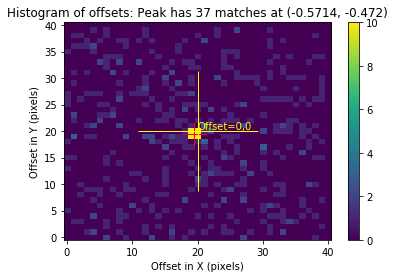

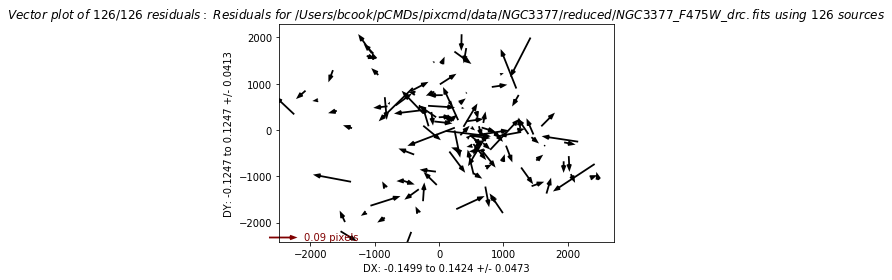

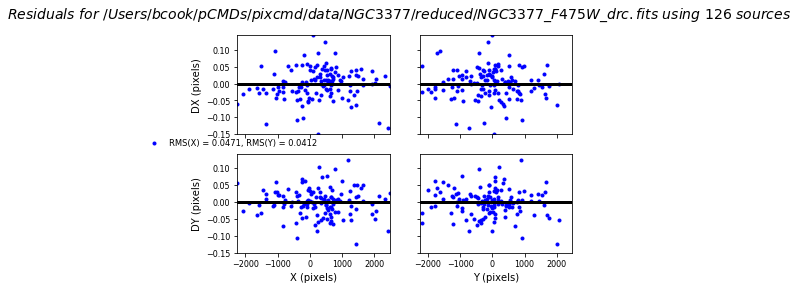

In [6]:
from drizzlepac import tweakreg
tweakreg.TweakReg([outputs['F850LP'], outputs['F475W']], conv_width=4.0, threshold=100, nclip=10, shiftfile=False, writecat=False, clean=True,
                 interactive=False, updatehdr=False)

In [14]:
# Create difference image to check alignment
f1 = fits.open(outputs['F850LP'])
f2 = fits.open(outputs['F475W'])
data = f2['SCI'].data / f1['SCI'].data
hdulist = fits.HDUList([fits.PrimaryHDU(), fits.ImageHDU(data=data)])
hdulist.writeto(diff_im, overwrite=True)

# Automatic Source Extraction

In [12]:
%%time
box = 8
ppy.data.sources.estimate_background(outputs['F850LP'], bkg_kwargs={'bw':box, 'bh':box})

CPU times: user 2min 17s, sys: 4.46 s, total: 2min 22s
Wall time: 2min 26s


In [13]:
%%time
ppy.data.sources.mask_sources_auto(outputs['F850LP'], threshold=10.0)

CPU times: user 3.39 s, sys: 4.39 s, total: 7.78 s
Wall time: 9.03 s


# Manual Source Extraction

In [14]:
ppy.data.sources.mask_sources_manual(outputs['F850LP'], '../data/NGC3377/masks/NGC3377_F850LP.reg')

In [15]:
# compute regions using only source masks
ppy.data.sources._add_masked(outputs['F850LP'], mask_flags=[ppy.data.utils.ALL_FLAGS['SEXTRACTOR'],
                                                            ppy.data.utils.ALL_FLAGS['MANUAL']])

# Combine Masks

In [16]:
ppy.data.utils.combine_flags(outputs)

# Compute Regions

In [5]:
ppy.data.extraction.add_regions(outputs, '../data/NGC3377/masks/NGC3377_F850LP_contours.reg', base_filter='F850LP', xc=3050, yc=2704)

100%|██████████| 82/82 [06:32<00:00,  4.79s/it]


# Extract PCMDs

In [6]:
pcmds = ppy.data.extraction.save_pcmds(outputs, 'F850LP', 'F475W', path='../data/NGC3377/pcmds/', name_append='NGC3377_z_gz')

Filter: F850LP
Observation Date: 53748 (MJD)
Vega ZeroPoint: 24.3512
AB ZeroPoint: 24.8770
ST ZeroPoint: 25.9650
Exposure Time: 3005.0
A pre-made filter is available
Filter: F475W
Observation Date: 53748 (MJD)
Vega ZeroPoint: 26.1702
AB ZeroPoint: 26.0776
ST ZeroPoint: 25.7668
Exposure Time: 1380.0
A pre-made filter is available


100%|██████████| 324/324 [00:40<00:00,  7.91it/s]


# Check

In [5]:
pcmds = {}
for i in tqdm(range(1, 324)):
    filename = f'../data/NGC3377/pcmds/NGC3377_z_gz_{i}.pcmd'
    try:
        pcmds[i] = np.loadtxt(filename, unpack=True)
    except OSError:
        continue
    if len(pcmds[i]) == 0:
        pcmds.pop(i)
        os.remove(filename)

100%|██████████| 323/323 [00:40<00:00,  7.90it/s]


In [6]:
keys = np.array(list(pcmds.keys()))

In [7]:
keys

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [8]:
Neffs = {i: np.sqrt(pcmds[i].shape[1]) for i in pcmds.keys()}

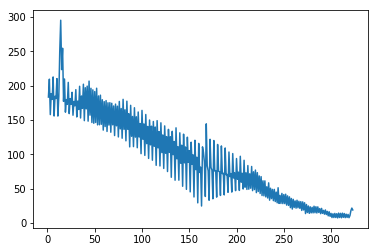

In [9]:
plt.plot(Neffs.keys(), Neffs.values())

In [10]:
f = ppy.instrument.default_ngc3377_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)

In [12]:
driv = ppy.driver.Driver(iso_model, gpu=False)

In [14]:
dmod = 30.18

In [27]:
gal_3 = ppy.galaxy.SSPSimple(np.array([0., -2., 3., 10.]), dmod=dmod)
gal_4 = ppy.galaxy.SSPSimple(np.array([0., -2., 4., 10.]), dmod=dmod)
gal_5 = ppy.galaxy.SSPSimple(np.array([0., -2., 5., 10.]), dmod=dmod)
gal_6 = ppy.galaxy.SSPSimple(np.array([0., -2., 6., 10.]), dmod=dmod)

In [28]:
sky = [126.9, 76.5]

In [29]:
pcmd_3, _ = driv.simulate(gal_3, 256, sky_noise=sky)
pcmd_4, _ = driv.simulate(gal_4, 256, sky_noise=sky)
pcmd_5, _ = driv.simulate(gal_5, 256, sky_noise=sky)
pcmd_6, _ = driv.simulate(gal_6, 256, sky_noise=sky)

In [30]:
is_dark = False
for i in tqdm(np.unique((keys-1)//4)):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 8), sharex=True, sharey=True)
    axes = [axes[0,1], axes[0,0], axes[1,0], axes[1,1]] # 4 quadrants
    for j in range(4):
        k = j + 1 + 4*i
        if k not in pcmds:
            continue
        pcmd = pcmds[k]
        ppy.plotting.plot_pcmd(pcmd, ax=axes[j])
        ppy.plotting.plot_pcmd_contours(pcmd_3, keep_limits=True, ax=axes[j], alpha=0.3, color=('w' if is_dark else 'k'))
        ppy.plotting.plot_pcmd_contours(pcmd_4, keep_limits=True, ax=axes[j], alpha=0.3, color=('w' if is_dark else 'k'))
        ppy.plotting.plot_pcmd_contours(pcmd_5, keep_limits=True, ax=axes[j], alpha=0.3, color=('w' if is_dark else 'k'))
        ppy.plotting.plot_pcmd_contours(pcmd_6, keep_limits=True, ax=axes[j], alpha=0.3, color=('w' if is_dark else 'k'))
        axes[j].set_title('Region {:d}, Neff = {:.0f}'.format(k, np.sqrt(pcmd.shape[1])))
        ppy.plotting.plot_isochrone(iso_model, dmod=30.25, axes=axes[j], mag_system='vega')
        axes[j].axhline(y=f[0].counts_to_mag(sky[0]), color='r', ls='--')
    axes[0].set_xlim([0, 3])
    axes[0].set_ylim([30, 22])
    plt.tight_layout()
    plt.savefig(f'figures/NGC3377/NGC3377_s{i}_pcmds.pdf')
    plt.close()

100%|██████████| 81/81 [01:41<00:00,  1.25s/it]
